<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Предобработка данных</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#DecisionTreeClassifier" data-toc-modified-id="DecisionTreeClassifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>DecisionTreeClassifier</a></span></li><li><span><a href="#RandomForestClassifier" data-toc-modified-id="RandomForestClassifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>RandomForestClassifier</a></span></li><li><span><a href="#Сравнение-результатов-моделей" data-toc-modified-id="Сравнение-результатов-моделей-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Сравнение результатов моделей</a></span></li><li><span><a href="#Тестирование-лучшей-модели" data-toc-modified-id="Тестирование-лучшей-модели-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Тестирование лучшей модели</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
!pip install wordcloud -q
!pip install --upgrade Pillow -q

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk import pos_tag
from wordcloud import WordCloud
from tqdm.notebook import tqdm

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score

RANDOM_STATE = 12345
TEST_SIZE = 0.1

In [3]:
# откроем данные из файла
try:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')
except:
    data = pd.read_csv('toxic_comments.csv')

In [4]:
data.sample(5)

,Unnamed: 0,text,toxic
37544,37590,Witch hunting. Only conspiracy theorists look ...,0
61151,61218,"""\nCorrection, I was blocked because you made ...",0
67830,67898,"""\n\nBehzādān Pour Vandād Hormuzd\n\nHello.\n\...",0
54776,54837,"""==Image source problem with Image:Visuel2.jpg...",0
69820,69889,Removal of college material\nIt's probably ok ...,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [6]:
# Удалим столбец дублирующий индекс
data = data.drop(columns=['Unnamed: 0'])

In [7]:
# Проверим на пропуски
data.isna().sum()

text     0
toxic    0
dtype: int64

In [8]:
# Проверим на дубликаты
data.duplicated().sum()

0

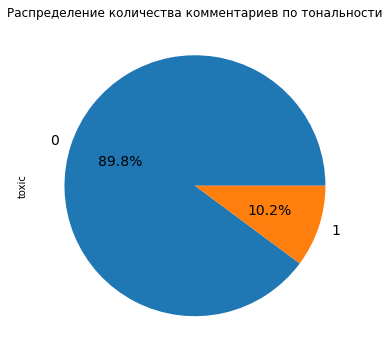

In [9]:
data.toxic.value_counts().plot.pie(autopct='%1.1f%%', figsize=(6, 6), fontsize=14)
plt.title('Распределение количества комментариев по тональности');

Наблюдается дисбаланс классов.

**Посмотрим на слова преобладающие в тексте.**

<function matplotlib.pyplot.show(close=None, block=None)>

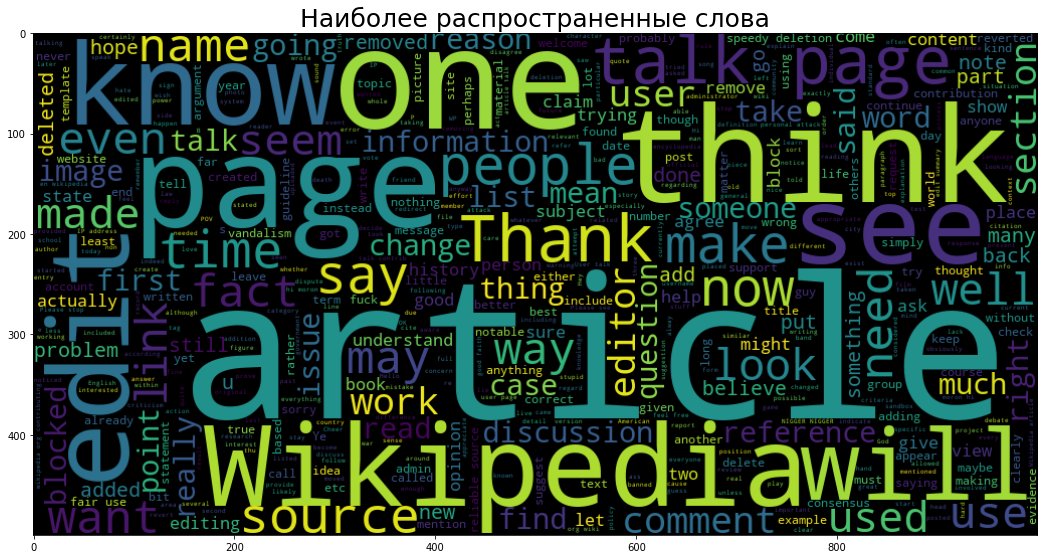

In [10]:
plt.figure(figsize=(18,18))
text = ' '.join(data['text'].values)
WC = WordCloud(width=1000, height=500, max_words=500, min_font_size=5)
cloud = WC.generate(text)
plt.imshow(cloud, interpolation='bilinear')
plt.title('Наиболее распространенные слова', fontdict = {'fontsize' : 25})
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

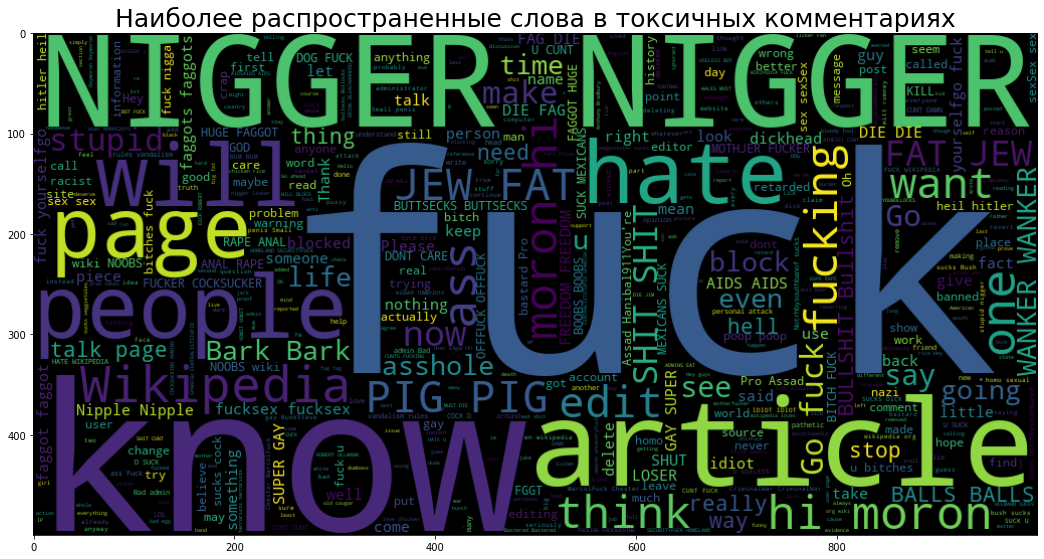

In [11]:
plt.figure(figsize=(18,18))
text = ' '.join(data[data['toxic']==1]['text'].values)
WC = WordCloud(width=1000, height=500, max_words=500, min_font_size=5)
cloud = WC.generate(text)
plt.imshow(cloud, interpolation='bilinear')
plt.title('Наиболее распространенные слова в токсичных комментариях', fontdict = {'fontsize' : 25})
plt.show

Грубость и ненормативная лексика в токсичных комментариях сразу бросается в глаза.

### Предобработка данных

In [12]:
nltk.download('punkt')      
nltk.download('wordnet')    
nltk.download('stopwords') 
nltk.download('averaged_perceptron_tagger')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
tqdm.pandas()

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [13]:
def clear_text(text):
    text = re.sub(r'[^a-zA-Z ]', ' ', text).lower()
    clear_text = " ".join(text.split())

    return clear_text

In [14]:
data['clear_text'] = data['text'].apply(clear_text)

In [15]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [16]:
def lemmatize(word):
    lemmatizer = WordNetLemmatizer()
    lemm_word = lemmatizer.lemmatize(word, get_wordnet_pos(word))
    
    return "".join(lemm_word)

In [17]:
data['lemm_text'] = data['clear_text'].progress_apply(lambda text: 
                                             (" ".join([lemmatize(word) for word in word_tokenize(text)])))

  0%|          | 0/159292 [00:00<?, ?it/s]

In [46]:
data.sample(3)

,text,toxic,clear_text,lemm_text
119865,Wikipedia:WikiProject Films/Assessment/U2 3D \...,0,wikipedia wikiproject films assessment u d thi...,wikipedia wikiproject film assessment u d this...
6780,"""\n\n Oscar Schmidt \n\nSorry, but you said """"...",1,oscar schmidt sorry but you said jordan would ...,oscar schmidt sorry but you say jordan would d...
125579,Edit request on 25 September 2012 \nPolice: St...,0,edit request on september police student suffe...,edit request on september police student suffe...


In [44]:
# Разделим данные на обучающую и тестовую выборки. Так как в данных присутствует дисбаланс классов используем stratify
X_train, X_test, y_train, y_test = train_test_split(data['lemm_text'],
                                                    data['toxic'],
                                                    stratify = data['toxic'],
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE)

print(X_train.shape)
print(X_test.shape)

(143362,)
(15930,)


In [20]:
vect = TfidfVectorizer(stop_words=stop_words, lowercase=False)

In [21]:
features_train = vect.fit_transform(X_train)
print(features_train.shape)

(143362, 142443)


In [22]:
features_test = vect.transform(X_test)
print(features_test.shape)

(15930, 142443)


## Обучение

### LogisticRegression

In [23]:
lr = LogisticRegression(solver='liblinear', n_jobs=-1, class_weight='balanced', random_state=RANDOM_STATE)

In [24]:
param_grid_lr = {
    'C': [0.5, 1, 5, 10],
    'penalty': ['l1', 'l2']
}

In [25]:
grid_search_lr = GridSearchCV(
    lr,
    param_grid_lr,
    n_jobs=-1,
    cv=5,
    scoring='f1'
)

In [26]:
%%time
grid_search_lr.fit(features_train, y_train)

CPU times: user 5min 17s, sys: 2min 50s, total: 8min 8s
Wall time: 8min 8s


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced', n_jobs=-1,
                                          random_state=12345,
                                          solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': [0.5, 1, 5, 10], 'penalty': ['l1', 'l2']},
             scoring='f1')

In [27]:
round(grid_search_lr.best_score_, 3)

0.758

In [28]:
grid_search_lr.best_params_

{'C': 10, 'penalty': 'l2'}

### DecisionTreeClassifier

In [30]:
tree = DecisionTreeClassifier(random_state=RANDOM_STATE)

In [31]:
%%time
result_tree = cross_val_score(tree, features_train, y_train, cv=3, scoring='f1')

CPU times: user 12min 28s, sys: 0 ns, total: 12min 28s
Wall time: 12min 28s


In [38]:
print(f"Среднее значение F1 на обучающей выборке: {result_tree.mean():.3f}")

Среднее значение F1 на обучающей выборке: 0.707


### RandomForestClassifier

In [34]:
rf = RandomForestClassifier(random_state=RANDOM_STATE)

In [35]:
%%time
result_rf = cross_val_score(rf, features_train, y_train, cv=3, scoring='f1')

CPU times: user 46min 30s, sys: 623 ms, total: 46min 31s
Wall time: 46min 33s


In [39]:
print(f"Среднее значение F1 на обучающей выборке: {result_rf.mean():.3f}")

Среднее значение F1 на обучающей выборке: 0.674


### Сравнение результатов моделей

In [41]:
# Соберем все результаты в одну таблицу
results = pd.DataFrame(data={'Метрика F1 на обучающей выборке' : [round(grid_search_lr.best_score_, 3), 
                                                                  round(result_tree.mean(), 3), 
                                                                  round(result_rf.mean(), 3)]},
                       index=['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier'])
results

,Метрика F1 на обучающей выборке
LogisticRegression,0.758
DecisionTreeClassifier,0.707
RandomForestClassifier,0.674


Лучший результат на тренировочных данных показала модель `LogisticRegression` с гиперпараметрами `C=10, penalty=l2`

### Тестирование лучшей модели

In [42]:
# Метрика f1 на тестовых данных лучшей модели
round(f1_score(y_test, grid_search_lr.predict(features_test)), 3)

0.766

## Выводы

Цель проекта заключалась в разработке и обучении модели машинного обучения, способной токсичные комментарии. Требовалось обеспечить хорошее качество модели по метрики F1=0.75.

Для достижения поставленной цели мы провели подготовку данных: очистили тексты комментариев, оставив только буквы английского алфавита и привели все их к нижнему регистру. Далее разделили текст на токены-слова, привели их к начальной форме и удалили стоп-слова.

В процессе знакомства с данными мы выявили дисбаланс в классах целевого признака. Чтобы минимизировать влияние дисбаланса классов мы применили метод `стратификации` при разделении данных на тренировочную и тестовую выборки, а так в алгоритме модели указали гиперпараметр `class_weight='balanced'`. 

TF-IDF обучался только на полных тренировочных данных для максимального увеличения словаря, после чего мы трансформировали тренировочную и тестовую выборки.

В решении поставленной задачи мы использовали несколько алгоритмов - LogisticRegression, DecisionTreeClassifier и SVC. Лучший результат на обучающей выборке показала модель `LogisticRegression` с гиперпараметрами `C=10, penalty=l2`. На тестовых данных мы получили результат `F1=0.766`
 
Можно так же попробовать использовать и другие алгоритмы, а так же и предобученные нейронные сети типа BERT. Улучшить значение заданной метрики может простое увелечение количества данных.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Модели обучены
- [ ]  Значение метрики *F1* не меньше 0.75
- [ ]  Выводы написаны